In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
import helper
import os
from sklearn.metrics import silhouette_samples, silhouette_score


In [19]:
%matplotlib inline

In [20]:
movies = pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [21]:
ratings = pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [22]:
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


In [23]:
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings


genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50


In [24]:
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset


biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  162


,index,avg_romance_rating,avg_scifi_rating
0,3,0.50,4.20
1,4,3.38,2.83
2,5,3.09,2.50
3,7,2.65,3.15
4,9,3.17,3.00


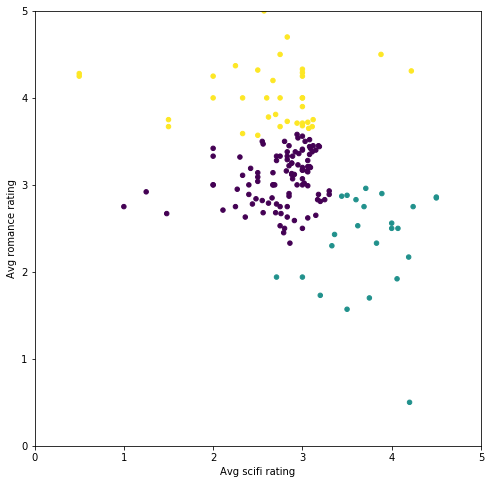

In [25]:
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values

from sklearn.cluster import KMeans

kmeans_1 = KMeans(n_clusters=3)

predictions = kmeans_1.fit_predict(X)

def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)

    
draw_clusters(biased_dataset, predictions)

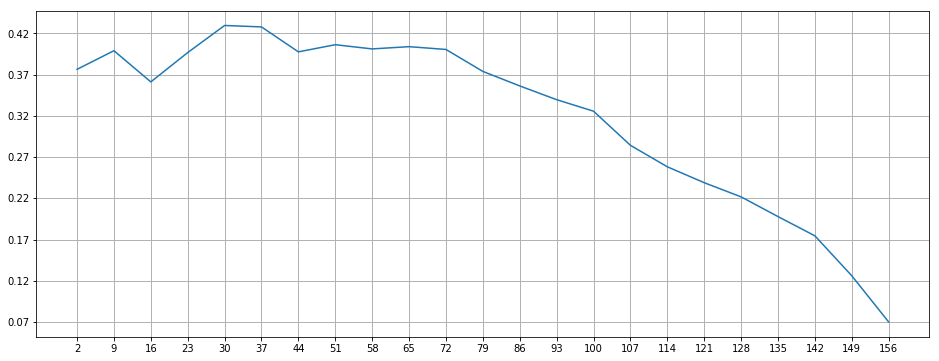

In [26]:

df = biased_dataset[['avg_scifi_rating','avg_romance_rating']]

possible_k_values = range(2, len(X)+1, 7)

def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

errors_per_k = [clustering_errors(k, X) for k in possible_k_values]

fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)


xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 7.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

In [27]:

ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]



dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


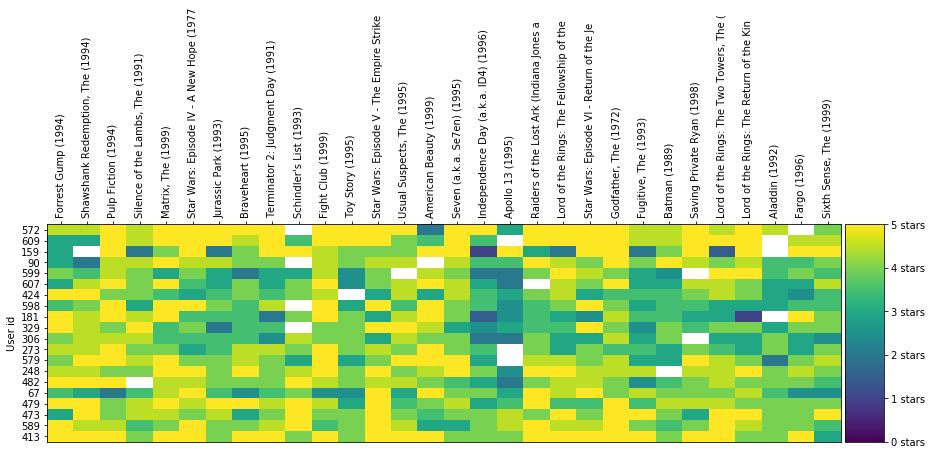

In [30]:
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

def get_users_who_rate_the_most(most_rated_movies, max_number_of_movies):
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))

    most_rated_movies_users = most_rated_movies.sort_values('counts', ascending=False)

    most_rated_movies_users_selection = most_rated_movies_users.iloc[:max_number_of_movies, :]
    most_rated_movies_users_selection = most_rated_movies_users_selection.drop(['counts'], axis=1)
    
    return most_rated_movies_users_selection

user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000)

n_movies = 30
n_users = 20

most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

 

def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    
    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()
    

    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')
      
    if axis_labels:
            ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
            ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
            ax.invert_yaxis()
            ax.xaxis.tick_top()
            labels = most_rated_movies_users_selection.columns.str[:40]
            ax.set_xticklabels(labels, minor=False)
            ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
            plt.setp(ax.get_xticklabels(), rotation=90)
    else:
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    ax.grid(False)
    ax.set_ylabel('User id')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
    plt.show()

      
draw_movies_heatmap(most_rated_movies_users_selection)






In [31]:
sparse_ratings = csr_matrix(pd.SparseDataFrame(most_rated_movies_1k).to_coo())
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings)
max_users = 100
max_movies = 50

clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)


In [44]:
cluster_number = 15

n_users = 50
n_movies = 300

cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)
cluster = sort_by_rating_density(cluster, n_movies, n_users)
cluster.fillna('').head(25)

,Forrest Gump (1994),"Matrix, The (1999)",Shrek (2001),Saving Private Ryan (1998),Star Wars: Episode VI - Return of the Jedi (1983),Star Wars: Episode V - The Empire Strikes Back (1980),Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),"Silence of the Lambs, The (1991)","Lord of the Rings: The Return of the King, The (2003)",...,Out of Sight (1998),Tron (1982),Air Force One (1997),"Crying Game, The (1992)",Blade (1998),Training Day (2001),"Firm, The (1993)",Hero (Ying xiong) (2002),Thelma & Louise (1991),Matchstick Men (2003)
21,5,3.5,4,4,3,3,3,3.5,4,4,...,,3,3,,3.5,,,3,4,
7,4,4,3,5,3.5,3,4,4,4,5,...,4,,3,3,,4,4,,,3.5
6,4,4.5,3.5,,2,2,2,,3.5,4,...,,,,,,,,3,3,
19,4.5,4,4,3.5,4,4,4,4,4,,...,,3.5,3.5,,3.5,4,3.5,,,
9,3,4,4,5,5,4,5,2,2,5,...,,,,,,,,,1,
24,5,5,5,4,3,4,4,4,4,,...,5,,,,4,,,,,
29,4,4.5,4,4,4,4,3.5,,,3.5,...,,,,,,,3.5,,,
22,3,4,1,3.5,3.5,3.5,3.5,2,2.5,3.5,...,,,3,,2,4,,,,
16,4.5,5,4.5,4.5,,,4,4,4,,...,,,,,,4.5,,,,4
2,5,5,5,4.5,3,4,2.5,3,4,5,...,4.5,,,4,,,,4,,5


In [45]:
user_id = 23

user_2_ratings  = cluster.loc[user_id, :]
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]

avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]

avg_ratings.sort_values(ascending=False)[:20]



Office Space (1999)                                     4.722222
Princess Bride, The (1987)                              4.500000
Mary Poppins (1964)                                     4.428571
Life Is Beautiful (La Vita è bella) (1997)              4.357143
Crash (2004)                                            4.357143
Four Weddings and a Funeral (1994)                      4.300000
Back to the Future (1985)                               4.289474
Spirited Away (Sen to Chihiro no kamikakushi) (2001)    4.285714
Back to the Future Part III (1990)                      4.272727
Lost in Translation (2003)                              4.250000
Snatch (2000)                                           4.227273
Apocalypse Now (1979)                                   4.214286
Goodfellas (1990)                                       4.200000
Big Fish (2003)                                         4.200000
Saving Private Ryan (1998)                              4.192308
Twelve Monkeys (a.k.a. 12